## A multivariate spatio-temporal prediction example with GNN + LSTM

This is for node-level regression problem with time-stampled features

Here I am using some simuated data just to demostrate.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Regerate simulated data with a clearer temporal trend

In [3]:
num_locations = 10  # Number of nodes/locations
num_features = 3  # Features: Signal, X1 and X2
num_timesteps = 100  # Time steps

# Generate initial signal randomly
initial_signal = torch.rand(num_locations) * 20 + 10  # Random signal between 10 and 30

# Generate a linear trend for each location (some increasing, some decreasing signal over time)
X1 = torch.randn(num_locations) * 0.1  # Small trends

# Create an empty tensor for the data
data = torch.zeros(num_timesteps, num_locations, num_features)

# Populate the data tensor with simulated signal data over time
for t in range(num_timesteps):
    noise = torch.randn(num_locations) * 0.1  # Random noise
    
    X2 = torch.randn(num_locations) * 0.05
    
    signal = initial_signal + X1 * t + X2*t + noise
    data[t, :, 0] = signal  # Signal
    data[t, :, 1] = X1  # X1
    data[t, :, 2] = X2  # X2


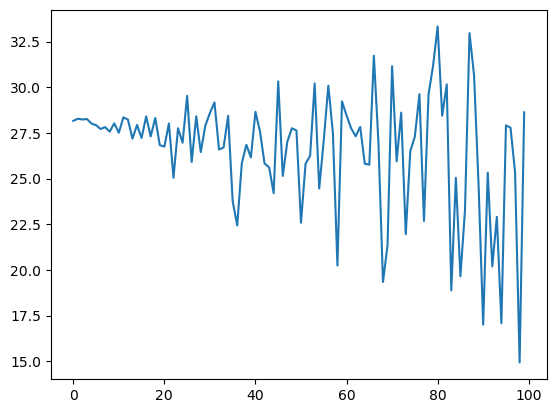

In [18]:
plt.plot(data[:, node, 0])

### Build the graph

For simlicity, here we don't add edge weights. You can review the basic GNN notebook on how to add edge weights into the GNN training.

In [4]:

# Generate edge index for the graph (simplified random connections)
edges = []
for i in range(num_locations):
    for j in range(i + 1, num_locations):
        if torch.rand(1) > 0.5:  # 50% chance to connect nodes, or can be a fixed threshold
            edges.append([i, j])
            edges.append([j, i])

edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Display shapes for confirmation
data.shape, edges.shape


(torch.Size([100, 10, 3]), torch.Size([2, 40]))

In [5]:
target_data = data[1:, :, 0]  # Only signal as target, exclude the last time step

# Adjust the input data to exclude the last time step to match the target data shape
input_data = data[:-1, :, :]  # Exclude the last time step

# Shapes of the adjusted input and target data
input_data.shape, target_data.shape

(torch.Size([99, 10, 3]), torch.Size([99, 10]))

### Generate temporal sequences

It is important to keep track of the shape of your data to understand which dimension is for what.

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the signal feature across the entire dataset (for simplicity)
scaler = MinMaxScaler()
# Flatten to fit scaler, then reshape to original
signal = data[:, :, 0].numpy().flatten().reshape(-1, 1)
normalized_temps = scaler.fit_transform(signal).reshape(num_timesteps, num_locations)


# Update the signal feature in the input data with normalized values
normalized_data = input_data.clone()
normalized_data[:, :, 0] = torch.tensor(normalized_temps[:-1, :])  # Exclude the last to match input_data


# Example of creating sequences (e.g., length=5)
sequence_length = 4

def create_sequences(input_data, target_data, sequence_length):
    sequences = []
    targets = []
    for i in range(input_data.shape[0] - sequence_length + 1):
        sequences.append(input_data[i:i+sequence_length])
        targets.append(target_data[i+sequence_length-1])
    return torch.stack(sequences), torch.stack(targets)

sequences, seq_targets = create_sequences(normalized_data, target_data, sequence_length)


In [7]:
sequences.shape, seq_targets.shape

(torch.Size([96, 4, 10, 3]), torch.Size([96, 10]))

### Train/Test Split

In [8]:
# Calculate the number of sequences for training (e.g., 80% for training)
num_train_sequences = int(sequences.size(0) * 0.8)

# Split the sequences and their targets into training and testing sets
train_sequences = sequences[:num_train_sequences]
train_seq_targets = seq_targets[:num_train_sequences]

test_sequences = sequences[num_train_sequences:]
test_seq_targets = seq_targets[num_train_sequences:]


### Create DataLoader with a certain batch size

In [9]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset objects
train_dataset = TensorDataset(train_sequences, train_seq_targets)
test_dataset = TensorDataset(test_sequences, test_seq_targets)

# Specify batch size
batch_size = 32  # Adjust as needed

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Our main SpatialTemporalModel

The model will use Convolutional GNN on the graph structure to capture the spatial dependencies of the data, then the embedded features will be passed on to LSTM for temporal prediction. You can then add fully connected layers if you want.

In [10]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class SpatialTemporalModel(nn.Module):
    def __init__(self, num_node_features, num_locations, GNN_hidden_nodes=32, LSTM_hidden_nodes=16, past_time_steps=4):
        
        super(SpatialTemporalModel, self).__init__()
        
        self.num_node_features =  num_node_features
        self.num_locations = num_locations
        self.past_time_steps = past_time_steps
        
        self.GNN_hidden_nodes = GNN_hidden_nodes
        self.LSTM_hidden_nodes = LSTM_hidden_nodes
        
        
        #GNN
        self.gnn = GCNConv(num_node_features, GNN_hidden_nodes)
        
        #LSTM
        self.lstm = nn.LSTM(GNN_hidden_nodes, LSTM_hidden_nodes, batch_first=True)
        
        #A fully connected layer
        self.fc1 = nn.Linear(LSTM_hidden_nodes, 4)
        
        #Final output
        self.linear = nn.Linear(4, 1)
    
    
    def forward(self, data, edge_index, batch_size):
        # Process each time step with GNN
        
        #For each timestamp, we capture the spatial dependences and generate spatial embeddings.
        #spatial embeddings are simply the convoluted layers as the result from GNN.
        spatial_embeddings = [self.gnn(data[:, time_step, :], edge_index) for time_step in range(data.size(1))]
        spatial_embeddings = torch.stack(spatial_embeddings, dim=1)
        
        # Initialize LSTM
        h0 = torch.zeros(1, spatial_embeddings.size(0), self.LSTM_hidden_nodes)
        c0 = torch.zeros(1, spatial_embeddings.size(0), self.LSTM_hidden_nodes)
    
        # LSTM processes the sequence of spatial embeddings
        lstm_out, (hn, cn) = self.lstm(spatial_embeddings,(h0, c0))
        
        #Get the last timestamp as the final prediction for each node.
        out = lstm_out.view(-1, self.past_time_steps, self.num_locations, self.LSTM_hidden_nodes)[:,-1,:,:]
         
        #Go through the fully connected layer
        out = self.fc1(out)
    
        out = F.relu(out)
    
        out = self.linear(out) 
        
        return out


### Model Init

In [11]:
import torch.optim as optim

# Assuming the SpatialTemporalModel class is defined as previously discussed

# Initialize the model
# num_node_features: The number of features per node (3 in our case: normalized signal, X1, X2)
# num_classes: The output feature dimension (1 in our case, predicting signal)
model = SpatialTemporalModel(num_node_features=3,num_locations=10, past_time_steps=sequence_length)

# Loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

### Model training

In [12]:
train_losses = []
val_losses = []

epochs = 1000

# Training loop

for epoch in tqdm(range(epochs)):
    
    pred_list = []
    y_list = []
    epoch_loss = 0
    
    model.train()
    
    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        
        # Assuming each batch is a sequence of graphs
        # And your model accepts (x, edge_index, batch) as inputs
        # You might need to adjust how you're passing the edge_index and batch here,
        # depending on how your model is implemented.
        batch_features = batch_features.view(-1, num_locations, num_features)  # Adjust shape as necessary
        
        batch_predictions = model(batch_features, edges, batch_size=batch_size)
        
        # Calculate loss - ensure batch_targets is the correct shape
        loss = criterion(batch_predictions[:,:,0].view(-1, 1), batch_targets.view(-1, 1))  # Adjust target shape as necessary

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        pred_list.append(batch_predictions.detach().numpy())
        y_list.append(batch_targets)
    
    train_losses.append(epoch_loss / len(train_loader))
    
    #turn on evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_features = batch_features.view(-1, num_locations, num_features)  # Adjust shape as necessary
        
            batch_predictions = model(batch_features, edges, batch_size=32)
        
            loss = criterion(batch_predictions[:,:,0].view(-1, 1), batch_targets.view(-1, 1))
            
            val_loss += loss.item()
            
            pred_list.append(batch_predictions.detach().numpy())
            y_list.append(batch_targets)
            
        #store the average loss
    val_losses.append(val_loss / len(test_loader))
    


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 94.27it/s]


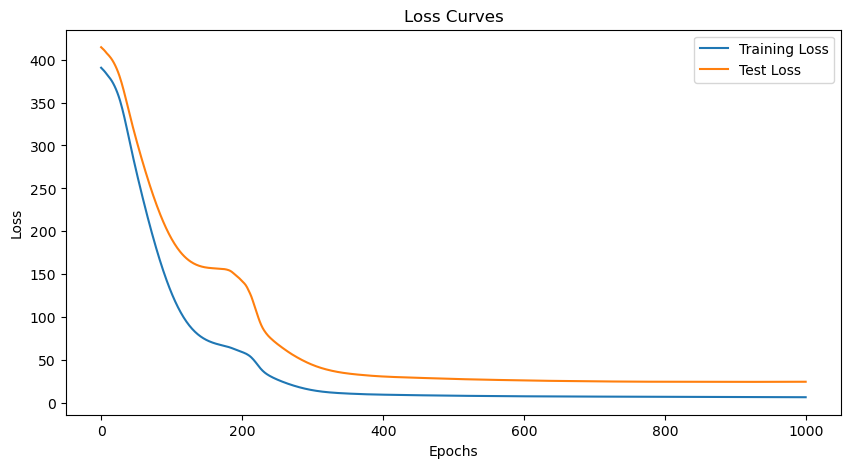

In [13]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim(0,200)
#plt.ylim(0,50)
plt.legend()
plt.show()

### Check the time-series prediction at different node/location

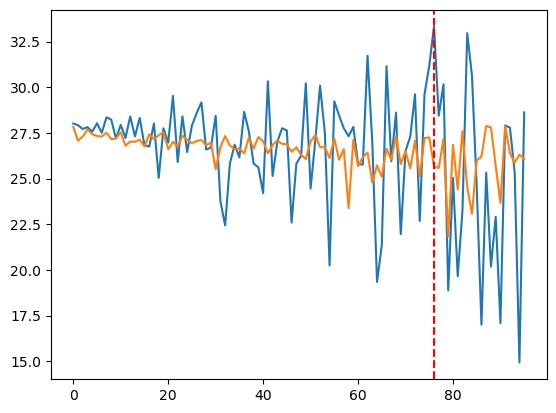

In [20]:
node = 2

plt.plot(np.vstack(y_list)[:,node])
plt.plot(np.vstack(pred_list)[:,node,:])

plt.axvline(x = num_train_sequences, color = 'r',ls='--')